In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import geopandas

from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
from fuzzywuzzy import fuzz, process
from shapely.geometry import Point, MultiPoint, Polygon

%matplotlib inline

/Users/aRa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Import data of italian regions from Protezione Civile
df_data = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
                            parse_dates=['data'])

df_data['data'] = df_data['data'].dt.date # Get only day part without timezone information
df_data.set_index(['data','denominazione_regione'], inplace=True)

region_names = df_data.index.get_level_values(1).unique().tolist() # Save region names
print(region_names)

['Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', "Valle d'Aosta", 'Veneto']


## Last day's data
Show data updated to last day

In [3]:
df_lastday = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv',
                            parse_dates=['data'])
df_lastday['data'] = df_lastday['data'].dt.date # Get only day part without timezone information
df_lastday.set_index(['data','denominazione_regione'], inplace=True)
df_lastday

stato  codice_regione        lat       long  \
data       denominazione_regione                                               
2020-04-10 Abruzzo                 ITA              13  42.351222  13.398438   
           Basilicata              ITA              17  40.639471  15.805148   
           P.A. Bolzano            ITA               4  46.499335  11.356624   
           Calabria                ITA              18  38.905976  16.594402   
           Campania                ITA              15  40.839566  14.250850   
           Emilia-Romagna          ITA               8  44.494367  11.341721   
           Friuli Venezia Giulia   ITA               6  45.649435  13.768136   
           Lazio                   ITA              12  41.892770  12.483667   
           Liguria                 ITA               7  44.411493   8.932699   
           Lombardia               ITA               3  45.466794   9.190347   
           Marche                  ITA              11  43.616760  13.518875   
           Molise                  ITA              14  41.557748  14.659161   
           Piemonte                ITA               1  45.073274   7.680687   
           Puglia                  ITA              16  41.125596  16.867367   
           Sardegna                ITA              20  39.215312   9.110616   
           Sicilia                 ITA              19  38.115697  13.362357   
           Toscana                 ITA               9  43.769231  11.255889   
           P.A. Trento             ITA               4  46.068935  11.121231   
           Umbria                  ITA              10  43.106758  12.388247   
           Valle d'Aosta           ITA               2  45.737503   7.320149   
           Veneto                  ITA               5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-04-10 Abruzzo                                   305                 53   
           Basilicata                                 59                 15   
           P.A. Bolzano                              258                 58   
           Calabria                                  168                 14   
           Campania                                  600                 90   
           Emilia-Romagna                           3596                349   
           Friuli Venezia Giulia                     167                 33   
           Lazio                                    1236                201   
           Liguria                                  1076                151   
           Lombardia                               11877               1202   
           Marche                                    925                127   
           Molise                                     28                  4   
           Piemonte                                 3497                394   
           Puglia                                    631                 80   
           Sardegna                                  107                 26   
           Sicilia                                   568                 62   
           Toscana                                  1011                256   
           P.A. Trento                               335                 70   
           Umbria                                    146                 39   
           Valle d'Aosta                             131                 16   
           Veneto                                   1521                257   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-04-10 Abruzzo                                 358   
           Basilicata                               74   
           P.A. Bolzano                            316   
           Calabria                                182   
           Campania       

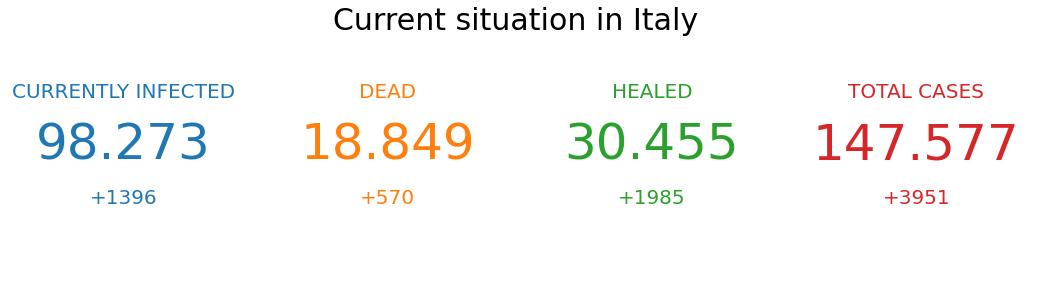

In [4]:
# Plot a summary of last day stats
totals = df_data.groupby(level='data').sum()
variations = totals - totals.shift(1)
variations = variations.iloc[-1]
totals = totals.iloc[-1]
#df_variations = 

cmap = ['#1f77b4', # totale_positivi
        '#ff7f0e', # dimessi_guariti
        '#2ca02c', # deceduti
        '#d62728'  # totale_casi
       ]

fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharey=False)

axs[0].text(0.5, 0.7, "CURRENTLY INFECTED", 
            size=20, ha="center", va="center", color=cmap[0])
axs[0].text(0.5, 0.5, "{:.3f}".format(totals['totale_positivi']/1000), 
            size=50, ha="center", va="center", color=cmap[0])
axs[0].text(0.5, 0.3, "{:+.0f}".format(variations['totale_positivi']), 
            size=20, ha="center", va="center", color=cmap[0])


axs[1].text(0.5, 0.7, "DEAD", 
            size=20, ha="center", va="center", color=cmap[1])
axs[1].text(0.5, 0.5, "{:.3f}".format(totals['deceduti']/1000), 
            size=50, ha="center", va="center", color=cmap[1])
axs[1].text(0.5, 0.3, "{:+.0f}".format(variations['deceduti']), 
            size=20, ha="center", va="center", color=cmap[1])


axs[2].text(0.5, 0.7, "HEALED", 
            size=20, ha="center", va="center", color=cmap[2])
axs[2].text(0.5, 0.5, "{:.3f}".format(totals['dimessi_guariti']/1000), 
            size=50, ha="center", va="center", color=cmap[2])
axs[2].text(0.5, 0.3, "{:+.0f}".format(variations['dimessi_guariti']), 
            size=20, ha="center", va="center", color=cmap[2])


axs[3].text(0.5, 0.7, "TOTAL CASES", 
            size=20, ha="center", va="center", color=cmap[3])
axs[3].text(0.5, 0.5, "{:.3f}".format(totals['totale_casi']/1000), 
            size=50, ha="center", va="center", color=cmap[3])
axs[3].text(0.5, 0.3, "{:+.0f}".format(variations['totale_casi']), 
            size=20, ha="center", va="center", color=cmap[3])

for s in np.arange(4):
    axs[s].get_xaxis().set_visible(False)
    axs[s].get_yaxis().set_visible(False)
    axs[s].set_frame_on(False)

fig.suptitle('Current situation in Italy', fontsize=30)
fig.tight_layout()
plt.show()

## The trend day by day
Currently positive, healed, dead and total cases from the first detection to today. Total data and new cases day by day.

In [5]:
# Prepare the data for the daily trend by selecting the relevant columns
columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi','tamponi']

df_data_totals = df_data.groupby(level='data').sum()
df_data_totals = df_data_totals[columns] #subset of selected columns

# Create new dataset fro daily totals
df_data_totals_daily = df_data_totals[columns].copy() 

for column in columns:
    # Calculate daily difference
    df_data_totals_daily[column] = df_data_totals_daily[column] - df_data_totals_daily[column].shift(1)

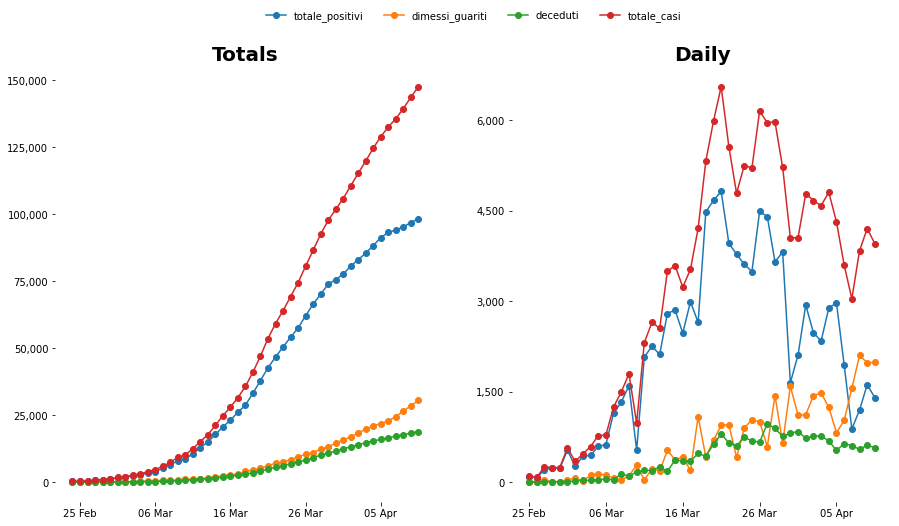

In [6]:
# Subset of columns to be plotted 
columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi']

# Plot side by side Total and Daily trends
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

for column in columns:
    axs[0].plot(df_data_totals[column],marker="o", label=column)
    axs[1].plot(df_data_totals_daily[column],marker="o", label=column)

# Common values for axis
for i in (0,1):
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(7))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
    axs[i].set_frame_on(False)
    
axs[0].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.1, 1.15), edgecolor='white') # Common legend for both plots
axs[0].set_title('Totals', fontsize=20, fontweight="bold")
axs[1].set_title('Daily', fontsize=20, fontweight="bold")

plt.show()

## The daily percentage change
How the growth in percentage terms of the total cases day by day varies.

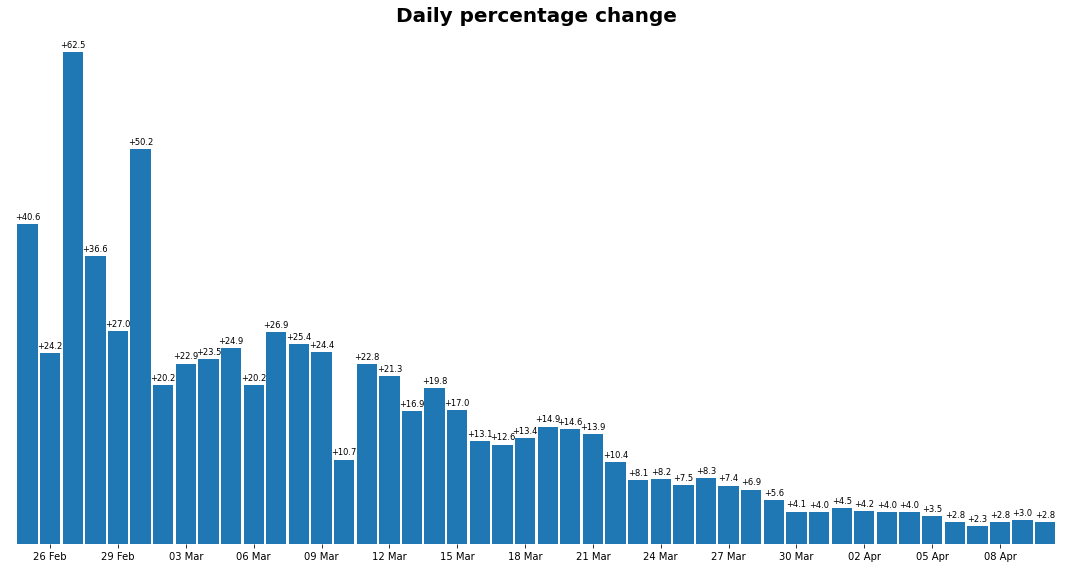

In [7]:
# Create a new dataset with percentages
df_variation_perc = (df_data_totals_daily['totale_casi']/
                             df_data_totals['totale_casi'].shift(1))*100
df_variation_perc.dropna(inplace=True)
x = mdates.date2num(df_variation_perc.index) # Convert dates to numbers for x axis
w = 0.9 # with of bars

fig, ax = plt.subplots(figsize=(15,8))

bars = ax.bar(x, df_variation_perc.round(1), width=w)

ax.set_title('Daily percentage change',fontsize=20, fontweight="bold")
ax.set_xlim(x.min()-w, x.max()+w)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Converts back x axes to dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

def autolabel(bars):
    """ Adds value above each bar """
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:+.1f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize='small',
                    ha='center', va='bottom')
autolabel(bars)

fig.tight_layout()

## Daily swabs and infected

The number of new infected people day by day, the number of daily tests and their percentage ratio.

In [8]:
df_data_totals_daily.tail()

,totale_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,
2020-04-06,1941.0,1022.0,636.0,3599.0,30271.0
2020-04-07,880.0,1555.0,604.0,3039.0,33713.0
2020-04-08,1195.0,2099.0,542.0,3836.0,51680.0
2020-04-09,1615.0,1979.0,610.0,4204.0,46244.0
2020-04-10,1396.0,1985.0,570.0,3951.0,53495.0


/Users/aRa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/aRa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


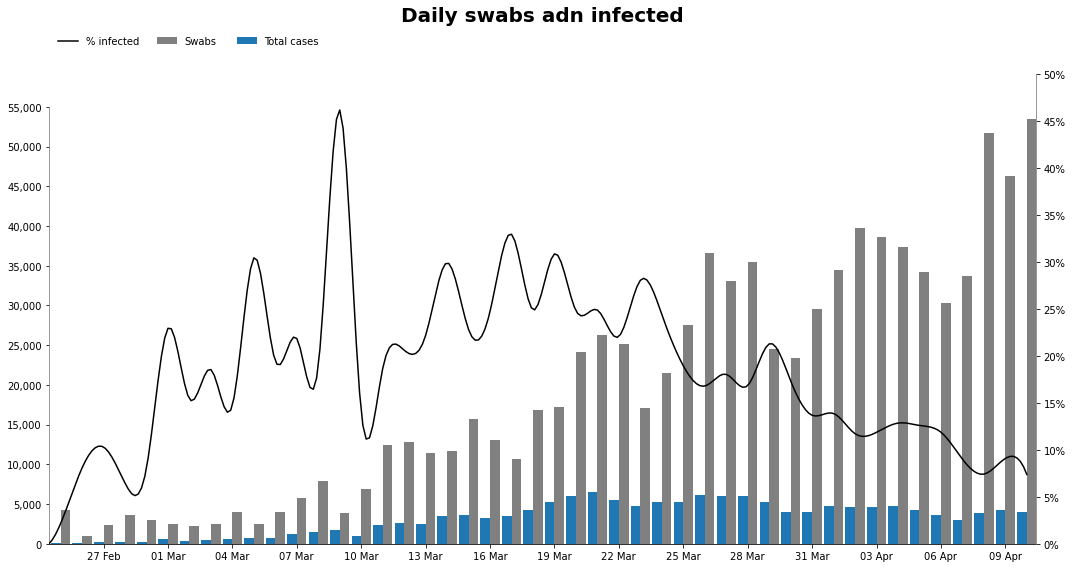

In [9]:
# Create a new dataset with swabs and infected
df_swabs_infected = df_data_totals_daily.copy()
df_swabs_infected['perc_contagiati_scoperti'] = (df_swabs_infected['totale_casi']/df_swabs_infected['tamponi'])*100
df_swabs_infected.fillna(0, limit=1, inplace=True) # Replace NaN by 0s

width = 0.45 # Width of the bars
x = mdates.date2num(df_swabs_infected.index) # Convert dates to numbers for x axis

ymax = df_swabs_infected['tamponi'].max()+5000.

# Smooth plot of percentages by interpolatation
xnew = np.linspace(x.min(),x.max(),300)
percentages = df_swabs_infected['perc_contagiati_scoperti']
spl = make_interp_spline(x, percentages, k=3)
percentages_smooth = spl(xnew)

##### Plot #####
fig, ax1 = plt.subplots(figsize=(15,8))

## Bars
bars1 = ax1.bar(x + width/2, df_swabs_infected['tamponi'], width, label='Swabs',color='grey')
bars2 = ax1.bar(x - width/2, df_swabs_infected['totale_casi'], width, label='Total cases')

ax1.set_title('Daily swabs adn infected', fontsize=20, fontweight="bold")

ax1.set_xlim(x.min()+width, x.max()+width)
ax1.set_ylim(0, ymax+2000.)

(ytick1_min, ytick1_max) = (ax1.get_yticks()[0], ax1.get_yticks()[-1])
newyticks1 = np.arange(ytick1_min, ytick1_max, step=5000.)

ax1.set_yticks(newyticks1)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3)) # Converts back x axes to dates and sets interval of dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax1.legend(ncol=2,loc='upper left', bbox_to_anchor=(0.1, 1), frameon=False)
ax1.spines['left'].set_color('grey')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_smart_bounds(True)

ax2 = ax1.twinx() # Add new axes to plot le percentages

## Percentages
perc = ax2.plot(xnew, percentages_smooth, color='k', label='% infected')

ax2.set_ylim(0, percentages_smooth.max()+5)

(ytick2_min, ytick2_max) = (ax2.get_yticks()[0], ax2.get_yticks()[-1])
newyticks2 = np.arange(ytick2_min, ytick2_max, step=5.)

ax2.tick_params(axis='y')
ax2.set_yticks(newyticks2)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%d%%')) # Format right axes
ax2.legend(loc='upper left',edgecolor='w')

ax2.spines['right'].set_color('grey')
ax2.spines['left'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_smart_bounds(True)


fig.tight_layout()

## The trend of the 5 regions with the most infections
The number of total cases in the 5 regions where coronavirus is most prevalent.

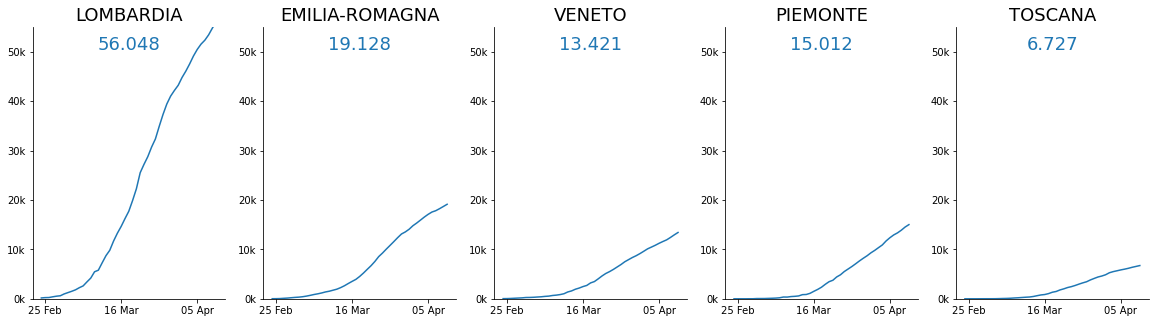

In [10]:
n = 5 # Number of cases

df_top_regions = df_data.groupby(level='denominazione_regione').sum() 
top_n_regions = df_top_regions.nlargest(n, 'totale_casi').index.tolist() # Names of top regions

df_trend_regions = df_data['totale_casi'].copy()

# Plot each single region side by side
fig, axs = plt.subplots(1, n, figsize=(20,5), sharey=True)

subplots = [0,1,2,3,4]
for s,region in zip(subplots, top_n_regions):
    maxval = df_trend_regions.xs(region, level='denominazione_regione').max()
    maxvaltext = '{:.3f}'.format(maxval/1000)
    
    # Common axes parameters
    axs[s].plot(df_trend_regions.xs(region, level='denominazione_regione'),label=maxval) # plot the single region
    axs[s].set_title('{}'.format(region.upper()), fontsize=18)
    axs[s].set_ylim(bottom=0, top=55000)
    axs[s].xaxis.set_major_locator(plt.MaxNLocator(3))
    axs[s].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[s].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(str(int(x/1000))+'k')))
    axs[s].spines['right'].set_visible(False)
    axs[s].spines['top'].set_visible(False)
    axs[s].yaxis.set_ticks_position('left')
    
    leg = axs[s].legend(loc='upper center', title=maxvaltext, frameon=False) # Plot total infected as legend
    plt.setp(leg.get_texts(), color='w')
    plt.setp(leg.get_title(), fontsize=18, color='#1f77b4')
    for item in leg.legendHandles:
        item.set_visible(False) # hide patch for each label
        
plt.show()

## The trend of intensive care and hospitalizations
The number of daily hospitalizations, those in intensive care, people in home isolation and the daily percentage growth. On the right, the percentage ratio between the individual items.

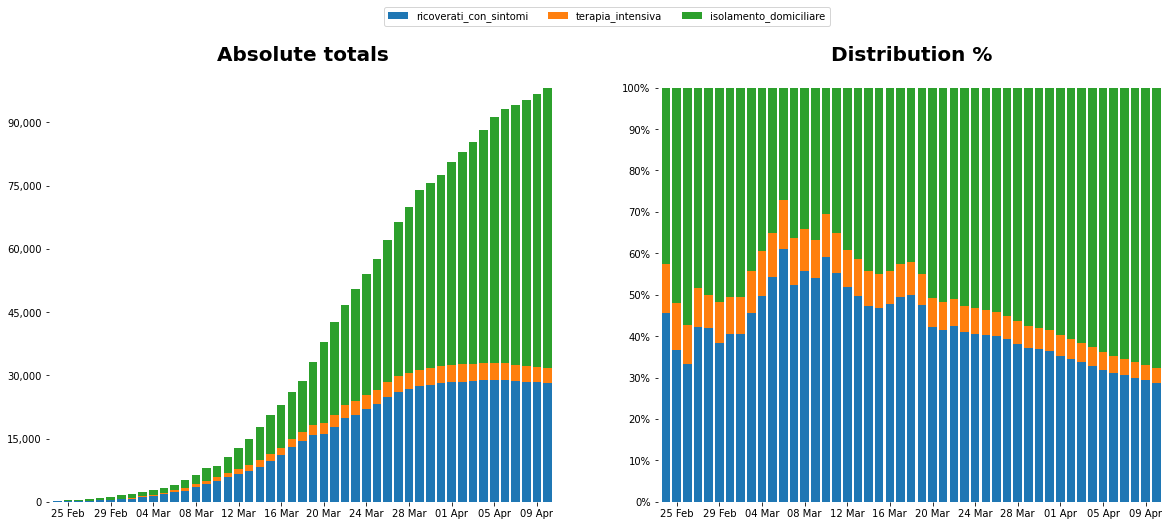

In [11]:
# Subset of columns to be plotted 
columns = ['ricoverati_con_sintomi','terapia_intensiva','isolamento_domiciliare','totale_positivi']
# Create a new dataset with columns selected
df_therapy = df_data[columns].copy()

# Group by date
df_therapy = df_therapy.groupby(level='data').sum()

# Create dataset with percentages
df_therapy_perc = df_therapy.copy()
df_therapy_perc['ricoverati_con_sintomi'] = (df_therapy_perc['ricoverati_con_sintomi']/df_therapy_perc['totale_positivi'])*100
df_therapy_perc['terapia_intensiva'] = (df_therapy_perc['terapia_intensiva']/df_therapy_perc['totale_positivi'])*100
df_therapy_perc['isolamento_domiciliare'] = (df_therapy_perc['isolamento_domiciliare']/df_therapy_perc['totale_positivi'])*100

# Prepare data for plot
x = mdates.date2num(df_therapy.index) # Convert dates to numbers for x axis
w = 0.8 # Width of the bars

# Plot side by side absolute totals and percentages
fig, axs = plt.subplots(1,2,figsize=(20,8),sharey=False)

# Absolute totals
axs[0].bar(x, df_therapy[columns[0]], label=columns[0])
axs[0].bar(x, df_therapy[columns[1]], label=columns[1], bottom=df_therapy[columns[0]])
axs[0].bar(x, df_therapy[columns[2]], label=columns[2], bottom=df_therapy[columns[0]]+df_therapy[columns[1]])
axs[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(1.1, 1.15))
axs[0].set_title('Absolute totals', fontsize=20, fontweight="bold")

# Percentages
axs[1].bar(x,df_therapy_perc[columns[0]], label=columns[0])
axs[1].bar(x,df_therapy_perc[columns[1]], label=columns[1], bottom=df_therapy_perc[columns[0]])
axs[1].bar(x,df_therapy_perc[columns[2]], label=columns[2], bottom=df_therapy_perc[columns[0]]+df_therapy_perc[columns[1]])
axs[1].set_title('Distribution %', fontsize=20, fontweight="bold")

# Common values for both subplots
for s in (0,1):
    axs[s].set_xlim(x.min()-w, x.max()+w)
    axs[s].set_frame_on(False)
    axs[s].xaxis.set_major_locator(mdates.DayLocator(interval=4))
    axs[s].xaxis.set_major_formatter(mdates.DateFormatter('%d %b')) # Converts back x axes to dates and sets interval of dates

# Format y axis
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(10))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
axs[1].set_yticks(np.arange(0,110,10))

plt.show()

## The trend in the provinces with the most infections
The number of total cases in the ten provinces where coronavirus is most prevalent.

In [12]:
# Read data by provinces
df_data_provinces = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv',
                            parse_dates=['data'])

df_data_provinces['data'] = df_data_provinces['data'].dt.date

# Remove rows with 'In fase di definizione/aggiornamento'
mask = df_data_provinces['denominazione_provincia'] != 'In fase di definizione/aggiornamento'
df_data_provinces = df_data_provinces[mask]
provinces = df_data_provinces['denominazione_provincia'].unique().tolist()

# Set index
df_data_provinces.set_index(['data','denominazione_regione','denominazione_provincia'], inplace=True)

# Find top N provinces on last day
n = 10 
last_day = df_data_provinces.index.get_level_values(0)[-1]

#df_top_province = df_dati_province.groupby(level='denominazione_provincia').sum()
df_top_provinces = df_data_provinces.loc[last_day].groupby(level='denominazione_provincia').sum()
top_n_provinces = df_top_provinces.nlargest(n, 'totale_casi').index.tolist()
print(top_n_provinces)

['Milano', 'Brescia', 'Bergamo', 'Torino', 'Cremona', "Reggio nell'Emilia", 'Monza e della Brianza', 'Verona', 'Padova', 'Roma']


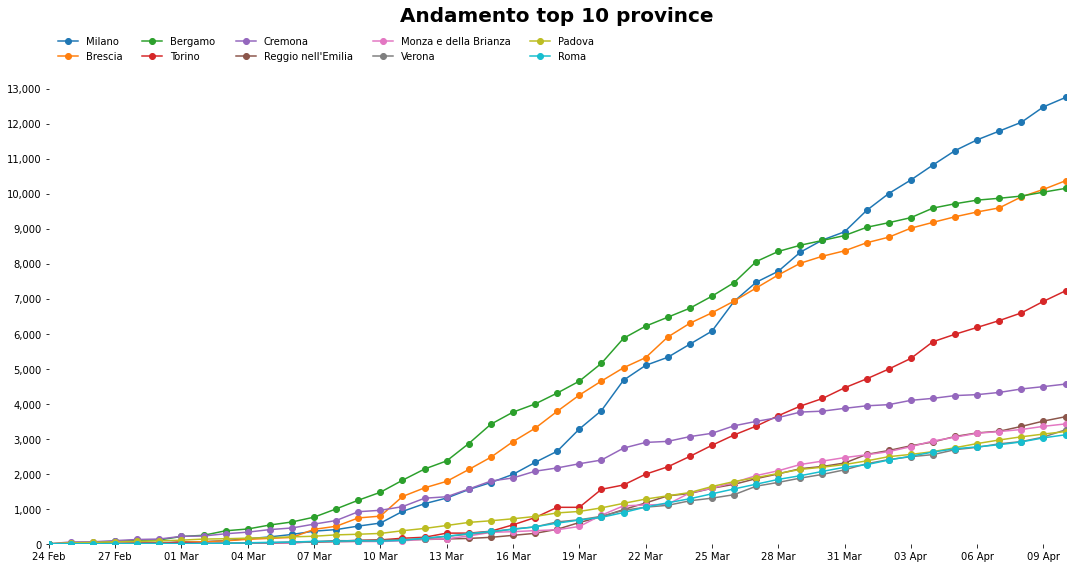

In [13]:
# Create dataset with provinces trend
df_trend_provinces = df_data_provinces['totale_casi'].copy()
df_trend_provinces = df_trend_provinces.droplevel('denominazione_regione') # Remove from index

# Prepare data for plot
x = mdates.date2num(df_trend_provinces.index.get_level_values(0)) # Convert dates to numbers for x axis
ymax = df_trend_provinces.max()+1000.
yticks = np.arange(0, ymax, step=1000.)

# Plot
fig, ax = plt.subplots(figsize=(15,8))

for province in top_n_provinces:
    ax.plot(df_trend_provinces.xs(province, level='denominazione_provincia'), marker="o", label=province)

ax.set_xlim(x.min(), x.max())
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b')) # Converts back x axes to dates and sets interval of dates
ax.set_ylim(0, ymax+1000.)
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) # Format numbers

ax.set_title('Andamento top {} province'.format(n), fontsize=20, fontweight="bold")
ax.legend(ncol=5,loc='upper left', frameon=False)

ax.set_frame_on(False)

fig.tight_layout() 

## The coronavirus map in Italy
The data of infections are aggregated by province and deaths by region.

In [14]:
col = ['lat','long','totale_casi']
df_data = df_data_provinces.loc[last_day][col]
df_data = df_data.droplevel('denominazione_regione')
df_data.name = 'province' # From italian to english
df_data.sort_index()

,lat,long,totale_casi
denominazione_provincia,,,
Agrigento,37.309711,13.584575,119
Alessandria,44.912974,8.615401,2119
Ancona,43.616760,13.518875,1501
Aosta,45.737503,7.320149,879
Arezzo,43.466428,11.882288,403
...,...,...,...
Vercelli,45.323981,8.423234,708
Verona,45.438390,10.993527,3257
Vibo Valentia,38.676241,16.101574,65


In [15]:
# Import GeoJSON data of italian provinces boundaries
#url_it_prov = 'https://gist.githubusercontent.com/datajournalism-it/212e7134625fbee6f9f7/raw/dabd071fe607f5210921f138ad3c7276e3841166/province.geojson'
with open('province.geojson') as f:
  italy_geojson = json.load(f)

# The total number of provinces
n_provinces = len(italy_geojson['features'])

# The provinces names
province_names = [italy_geojson['features'][k]['properties']['NOME_PRO'] for k in range(n_provinces)]
print("There are {} provinces".format(n_provinces))

There are 110 provinces


Depending on the resolution of your geojson and on the purpose of your map, you might consider downsampling the longitude and latitude coordinates. Downsampling the coordinates will decrease the resolution of the borders, but it will speed up the rendering time

In [16]:
def downsample(sample = 10):
    sources = []
    geojson_copy = copy.deepcopy(italy_geojson['features']) # do not oeverwrite the original file

    for feature in geojson_copy:

        if sample > 0:
            coords = np.array(feature['geometry']['coordinates'][0][0])
            coords = coords[::sample]
            feature['geometry']['coordinates'] = [[coords]]

        sources.append(dict(type = 'FeatureCollection',
                            features = [feature])
                      )
    return sources

In [17]:
# Extract geometryc coordinates of provinces
sources = downsample(5)
g_provinces = [sources[k]['features'][0]['geometry']['coordinates'] for k in range(n_provinces)]

Since my computer can't generate a Polygon with shapely, alternatively I'm using the MultiPoint class to represent the borders of the regions. The diference is that as a MultiPoint has no area, I'm not able to print all provinces colored, instead I'm plotting a scatter of total clases

In [18]:
def toPoint(list): 
    return Point(tuple(list))

# Genereate polygons of provinces
polygons = []
for i in np.arange(len(g_provinces)):
    points = [toPoint(g) for g in g_provinces[i][0][0]]
    polygons.append(Polygon(points))

d = {'denominazione_provincia':province_names, 'geometry': polygons}
df_mappa = pd.DataFrame(data=d)
df_mappa.set_index('denominazione_provincia', inplace=True)

In [19]:
# Match the province names of dataframe and geojson
def match_regions(list1, list2):
    # take only the best match
    matched = [process.extract(list1[i], list2, limit=1, scorer=fuzz.partial_ratio)[0][0] for i in range(0,len(list1))]

    return {key: value for (key, value) in zip(list1, matched)}

match_dict = match_regions(df_data.index, province_names)
print(match_dict)

{'Chieti': 'Chieti', "L'Aquila": "L'Aquila", 'Pescara': 'Pescara', 'Teramo': 'Teramo', 'Matera': 'Matera', 'Potenza': 'Potenza', 'Bolzano': 'Bolzano', 'Catanzaro': 'Catanzaro', 'Cosenza': 'Cosenza', 'Crotone': 'Crotone', 'Reggio di Calabria': 'Reggio Calabria', 'Vibo Valentia': 'Vibo Valentia', 'Avellino': 'Avellino', 'Benevento': 'Benevento', 'Caserta': 'Caserta', 'Napoli': 'Napoli', 'Salerno': 'Salerno', 'Bologna': 'Bologna', 'Ferrara': 'Ferrara', 'Forlì-Cesena': 'Forl\x8d-Cesena', 'Modena': 'Modena', 'Parma': 'Parma', 'Piacenza': 'Piacenza', 'Ravenna': 'Ravenna', "Reggio nell'Emilia": 'Reggio Emilia', 'Rimini': 'Rimini', 'Gorizia': 'Gorizia', 'Pordenone': 'Pordenone', 'Trieste': 'Trieste', 'Udine': 'Udine', 'Frosinone': 'Frosinone', 'Latina': 'Latina', 'Rieti': 'Rieti', 'Roma': 'Roma', 'Viterbo': 'Viterbo', 'Genova': 'Genova', 'Imperia': 'Imperia', 'La Spezia': 'La spezia', 'Savona': 'Savona', 'Bergamo': 'Bergamo', 'Brescia': 'Brescia', 'Como': 'Como', 'Cremona': 'Cremona', 'Lecco':

In [20]:
df_tmp = df_data.copy() # do not overwrite the dataframe
df_tmp.index = df_tmp.index.map(match_dict) # rename
df_tmp = df_tmp[~df_tmp.index.duplicated(keep=False)] # drop duplicates
                                                      # from fuzzy match gone wrong
# Give the same index order as the geojson
df_reindexed = df_tmp.reindex(index = province_names)
print(df_reindexed)

                               lat       long  totale_casi
denominazione_provincia                                   
Vercelli                 45.323981   8.423234        708.0
Novara                   45.445885   8.621916       1258.0
Torino                   45.073274   7.680687       7226.0
Cuneo                    44.393296   7.551172       1318.0
Valle d'Aosta            45.737503   7.320149        879.0
...                            ...        ...          ...
Catania                  37.502878  15.087047        672.0
Potenza                  40.639471  15.805148        161.0
Ragusa                   36.925092  14.730699         61.0
Isernia                  41.588008  14.225754         43.0
Barletta-Andria-Trani    41.227050  16.295204        243.0

[110 rows x 3 columns]


In [21]:
# Create a new dataset by adding geometry points to reindexed dataset
df_reindexed_map = df_reindexed.merge(df_mappa, left_index=True, right_index=True)
df_reindexed_map

,lat,long,totale_casi,geometry
denominazione_provincia,,,,
Vercelli,45.323981,8.423234,708.0,"POLYGON ((8.204465116243027 45.93567475731711,..."
Novara,45.445885,8.621916,1258.0,"POLYGON ((8.496878361658412 45.83933925448746,..."
Torino,45.073274,7.680687,7226.0,"POLYGON ((7.859044264361275 45.59758444387668,..."
Cuneo,44.393296,7.551172,1318.0,"POLYGON ((7.99089719465156 44.82381138833528, ..."
Valle d'Aosta,45.737503,7.320149,879.0,"POLYGON ((7.588571915813588 45.97075085043372,..."
...,...,...,...,...
Catania,37.502878,15.087047,672.0,"POLYGON ((15.09013209641676 37.49971885346178,..."
Potenza,40.639471,15.805148,161.0,"POLYGON ((15.72353494486009 39.96828910017415,..."
Ragusa,36.925092,14.730699,61.0,"POLYGON ((14.49320600045339 36.78657623003762,..."


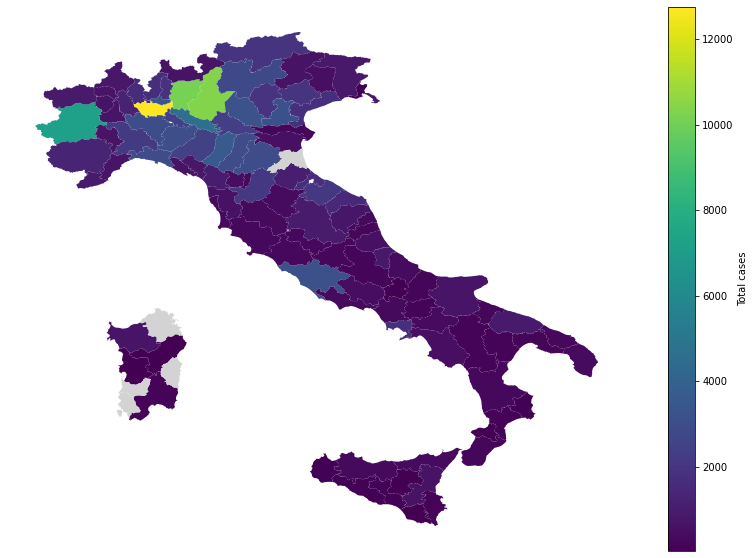

In [29]:
# Create geopandas dataset to plot the map
gdf = geopandas.GeoDataFrame(df_reindexed, geometry=geopandas.points_from_xy(df_reindexed.long, df_reindexed.lat))
italy = geopandas.GeoDataFrame(df_reindexed_map, geometry='geometry')

fig, ax = plt.subplots(figsize=(15,10))
italy.plot(ax=ax, column='totale_casi', cmap='viridis', legend=True,
          legend_kwds={'label': "Total cases"},
          missing_kwds={
              "color": "lightgrey",
              "label": "Missing values"
          })

ax.axis('off')

plt.show()